In [1]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

In [2]:
df = pd.read_csv('./data/mimic_premodel.csv')

In [3]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,...,leuko,mean_insp_pr,resp_rat,tidal_vol,breath_min_vol,ismale,icu_CSRU,icu_MICU,icu_SICU,icu_TSICU
0,1,100016,217590,56.0,11,6.1731,1,86.0,2.0,1.1,...,10.7,6.0,18.0,653.0,11.754,1,0,1,0,0
1,1,100017,258320,28.0,8,0.6924,0,171.0,4.0,0.8,...,9.3,6.4,20.0,430.0,8.600,1,0,1,0,0
2,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,17.2,6.0,16.0,151.0,2.416,1,0,1,0,0
3,1,100063,241782,46.0,11,1.6501,0,365.0,2.0,1.0,...,8.4,1.0,18.0,441.0,7.938,1,0,1,0,0
4,1,100087,294404,57.0,18,3.7287,0,143.0,5.0,0.7,...,8.5,7.0,17.0,481.0,8.177,1,0,0,0,0


# New features

## Weight

We want to calculate the BMI (Body Mass Index) from weight and height.

Last weight measurement before extubation.

In [30]:
df_weight = pd.read_csv('./data/weight_feature.csv')

In [31]:
df_weight.head()

,hadm_id,value,valueuom,charttime
0,100017,83.699997,kg,2103-03-11 09:04:00
1,100154,78.599998,kg,2120-12-18 12:59:00
2,100179,55.400002,kg,2135-12-27 14:33:00
3,100237,45.799999,kg,2165-01-11 20:30:00
4,100267,61.200001,kg,2102-06-03 15:07:00


In [77]:
df_weight.drop_duplicates(subset='hadm_id', inplace=True)

In [81]:
df_weight.hadm_id.nunique()

2749

In [82]:
df_weight.shape

(2749, 4)

In [66]:
df_height = pd.read_csv('./data/height_feature.csv')

In [67]:
df_height.head()

,hadm_id,value,valueuom
0,100016,54.0,Inch
1,100016,137.0,cm
2,100017,68.0,inches
3,100035,70.0,Inch
4,100035,178.0,cm


In [74]:
df_height.hadm_id.nunique()

3566

In [68]:
df_height.valueuom.unique()

array(['Inch', 'cm', 'inches', 'In'], dtype=object)

In [69]:
# unit transformation inch -> cm

df_height.value = np.where(df_height.valueuom =='Inch', 2.54 * df_height.value, df_height.value)
df_height.value = np.where(df_height.valueuom =='In', 2.54 * df_height.value, df_height.value)
df_height.value = np.where(df_height.valueuom =='inches', 2.54 * df_height.value, df_height.value)


In [70]:
df_height.head()

,hadm_id,value,valueuom
0,100016,137.16,Inch
1,100016,137.00,cm
2,100017,172.72,inches
3,100035,177.80,Inch
4,100035,178.00,cm


In [72]:
df_height.drop_duplicates(subset='hadm_id', inplace=True)

In [73]:
df_height.head()

,hadm_id,value,valueuom
0,100016,137.16,Inch
2,100017,172.72,inches
3,100035,177.80,Inch
5,100063,165.10,Inch
7,100074,162.56,inches


In [79]:
df_height.hadm_id.nunique()

3566

In [80]:
df_height.shape

(3566, 3)

In [83]:
df_weight_height= df_weight.merge(right=df_height, how= 'inner' , on='hadm_id', suffixes=('_w', '_h'))

In [84]:
df_weight_height.head()

,hadm_id,value_w,valueuom_w,charttime,value_h,valueuom_h
0,100017,83.699997,kg,2103-03-11 09:04:00,172.72,inches
1,100154,78.599998,kg,2120-12-18 12:59:00,154.94,inches
2,100267,61.200001,kg,2102-06-03 15:07:00,152.40,inches
3,100283,84.000000,kg,2168-12-06 22:19:00,170.18,inches
4,100319,74.300003,kg,2187-08-14 08:43:00,182.88,inches


In [85]:
df_weight_height.shape

(1195, 6)

Due to the small amount of available data on height and weight in our patients, we will no longer pursue the idea of calculating a BMI.


## Work of Breathing

Work of breathing (WOB) is the energy expended to inhale and exhale a breathing gas. 
Work of breathing is the product of pressure and volume for each breath.

In [4]:
df.eval('wob = mean_insp_pr * tidal_vol* 0.000133', inplace=True)

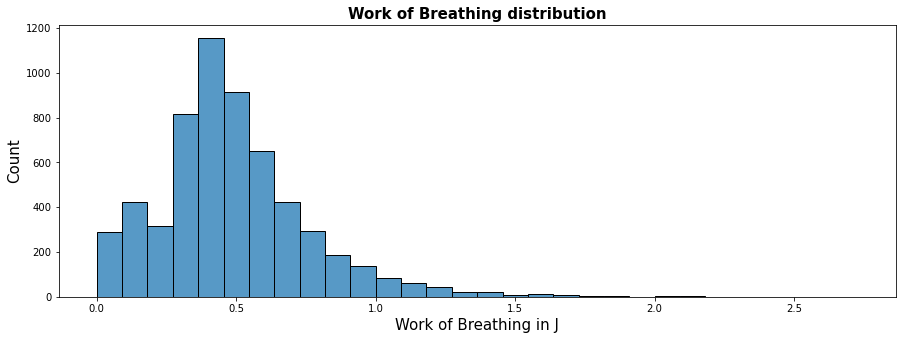

In [5]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.wob, bins=30)
ax.set_title("Work of Breathing distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Work of Breathing in J', fontsize=15);

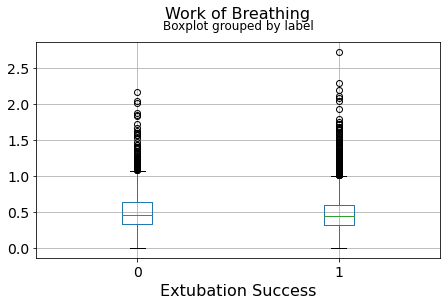

In [6]:
df.boxplot("wob",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Work of Breathing'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Rapid Shallow Breathing Index

The rapid shallow breathing index (RSBI) is a tool that is used in the weaning of mechanical ventilation on intensive care units.
The RSBI is defined as the ratio of respiratory frequency to tidal volume.

In [7]:
df.eval('rsbi = resp_rat / tidal_vol * 1000', inplace=True)

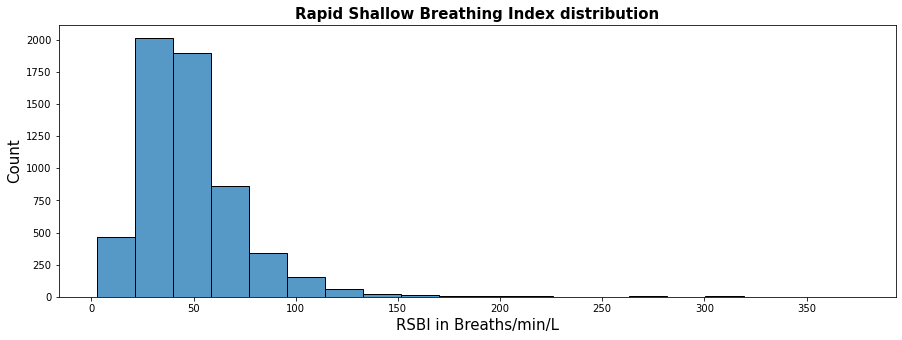

In [8]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.rsbi[df.rsbi < 400], bins=20)
ax.set_title("Rapid Shallow Breathing Index distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('RSBI in Breaths/min/L', fontsize=15);

In [9]:
len(df[df.rsbi>400])

25

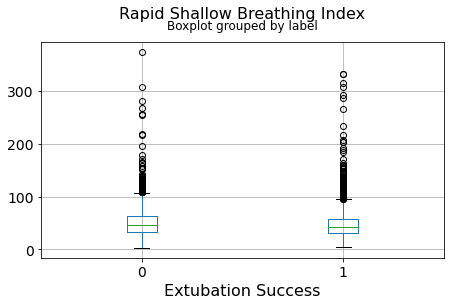

In [10]:
df[df.rsbi<400].boxplot("rsbi",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Rapid Shallow Breathing Index'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Duration of Ventilation

In [11]:
df_lomv =pd.read_csv('./data/duration_mechvent.csv')

In [12]:
df_lomv.head()

,icustay_id,hour_mechvent
0,200006,18.00
1,200059,176.50
2,200063,127.15
3,200065,228.00
4,200077,0.50


In [13]:
df= df.merge(right=df_lomv, how= 'inner' , on='icustay_id')

In [14]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,...,tidal_vol,breath_min_vol,ismale,icu_CSRU,icu_MICU,icu_SICU,icu_TSICU,wob,rsbi,hour_mechvent
0,1,100016,217590,56.0,11,6.1731,1,86.0,2.0,1.1,...,653.0,11.754,1,0,1,0,0,0.521094,27.565084,90.00
1,1,100017,258320,28.0,8,0.6924,0,171.0,4.0,0.8,...,430.0,8.600,1,0,1,0,0,0.366016,46.511628,5.50
2,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,151.0,2.416,1,0,1,0,0,0.120498,105.960265,194.48
3,1,100063,241782,46.0,11,1.6501,0,365.0,2.0,1.0,...,441.0,7.938,1,0,1,0,0,0.058653,40.816327,9.50
4,1,100087,294404,57.0,18,3.7287,0,143.0,5.0,0.7,...,481.0,8.177,1,0,0,0,0,0.447811,35.343035,71.17


In [15]:
df.shape

(5884, 31)

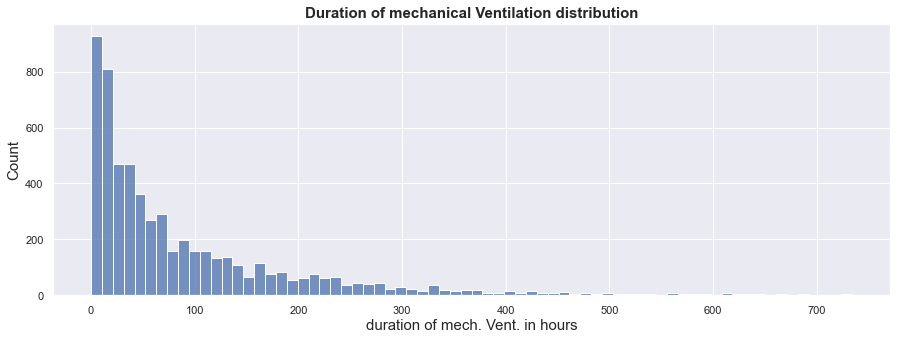

In [87]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.hour_mechvent[df.hour_mechvent<750], bins=70)
ax.set_title("Duration of mechanical Ventilation distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('duration of mech. Vent. in hours', fontsize=15);

In [17]:
len(df[df.hour_mechvent>750])

16

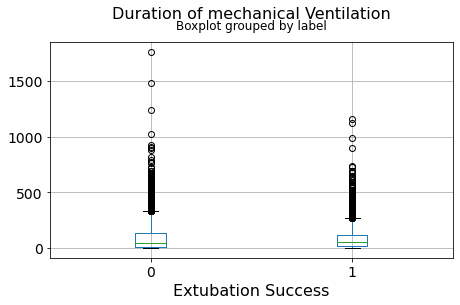

In [18]:
df.boxplot("hour_mechvent",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Duration of mechanical Ventilation'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Respiratory instability = PF Ratio

In [11]:
df.eval('pf_ratio =  PaO2/ FiO2 ', inplace=True)

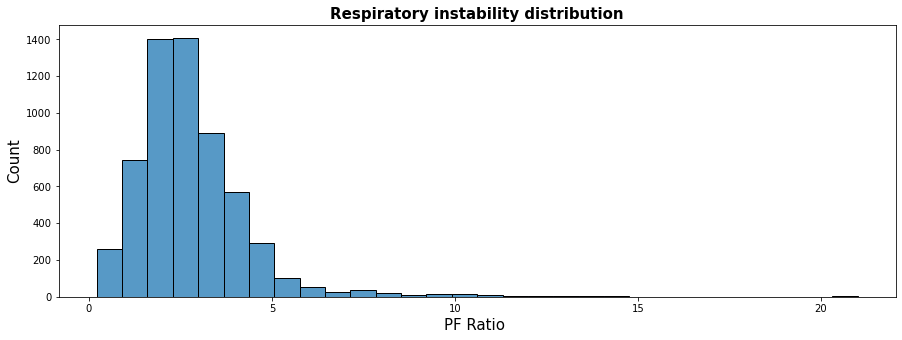

In [12]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.pf_ratio, bins=30)
ax.set_title("Respiratory instability distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('PF Ratio ', fontsize=15);

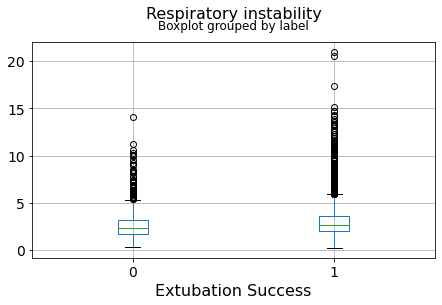

In [13]:
df.boxplot("pf_ratio",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Respiratory instability'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Product 1

In [14]:
df.eval('product1 = leuko*rsbi*FiO2 ', inplace=True)

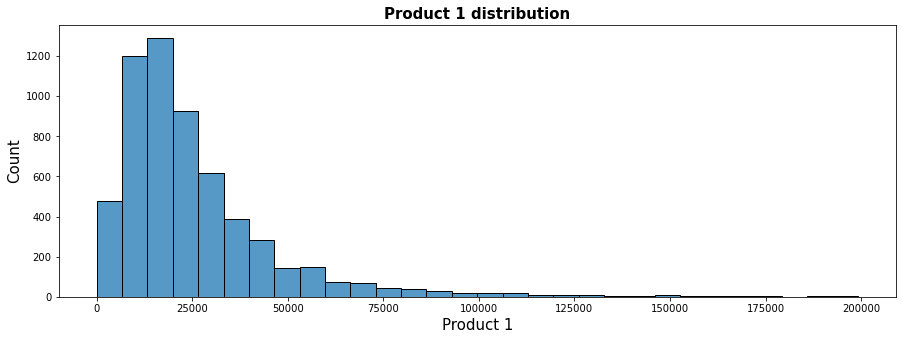

In [15]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.product1[df.product1<200000], bins=30)
ax.set_title("Product 1 distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Product 1', fontsize=15);

In [16]:
len(df[df.product1>200000])

38

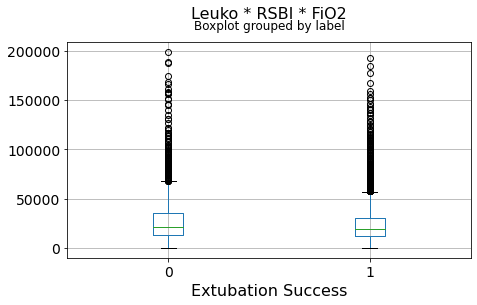

In [17]:
df[df.product1<200000].boxplot("product1",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Leuko * RSBI * FiO2'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Product 2

In [18]:
df.eval('product2 = hr * pf_ratio * wob ', inplace=True)

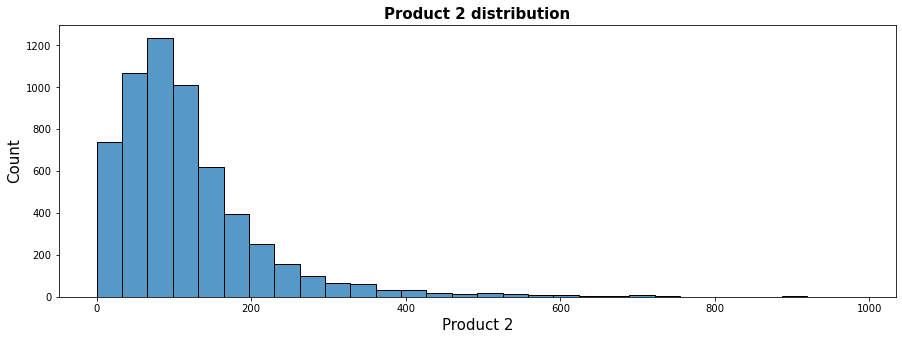

In [19]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.product2[df.product2<1000], bins=30)
ax.set_title("Product 2 distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Product 2', fontsize=15);

In [20]:
len(df[df.product2>1000])

6

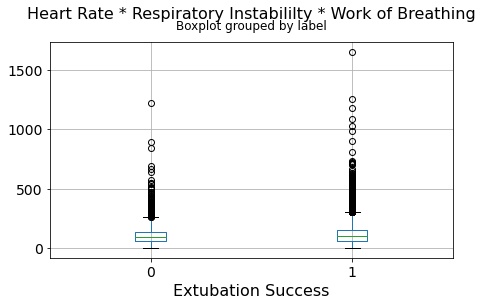

In [21]:
df.boxplot("product2",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Heart Rate * Respiratory Instabililty * Work of Breathing'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Certain diseases

In [19]:
df_disease = pd.read_csv('./data/Comorbidities_MIMIC_patients.csv')

In [20]:
df_disease.head()

,hadm_id,diabetes,kidney_failure,pneumonia,heart_failure,embolism
0,100016,0,0,0,0,0
1,100017,0,0,0,0,0
2,100035,0,1,0,1,0
3,100035,0,1,0,1,0
4,100035,0,1,0,1,0


In [21]:
df_disease.shape

(11096, 6)

In [22]:
df= df.merge(right=df_disease, how= 'inner' , on='hadm_id')

In [23]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,...,icu_SICU,icu_TSICU,wob,rsbi,hour_mechvent,diabetes,kidney_failure,pneumonia,heart_failure,embolism
0,1,100016,217590,56.0,11,6.1731,1,86.0,2.0,1.1,...,0,0,0.521094,27.565084,90.00,0,0,0,0,0
1,1,100017,258320,28.0,8,0.6924,0,171.0,4.0,0.8,...,0,0,0.366016,46.511628,5.50,0,0,0,0,0
2,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,0,0,0.120498,105.960265,194.48,0,1,0,1,0
3,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,0,0,0.120498,105.960265,194.48,0,1,0,1,0
4,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,0,0,0.120498,105.960265,194.48,0,1,0,1,0


In [24]:
df.shape

(10085, 36)

In [25]:
df.icustay_id.nunique()

5884

In [26]:
df.drop_duplicates(inplace=True)

In [27]:
df.columns

Index(['label', 'hadm_id', 'icustay_id', 'age', 'numb_diagn', 'los', 'tracheo',
       'PaO2', 'base_excess', 'creatinin', 'hb', 'pH', 'FiO2', 'PEEP', 'SaO2',
       'blood_pr', 'hr', 'lactic_acid', 'leuko', 'mean_insp_pr', 'resp_rat',
       'tidal_vol', 'breath_min_vol', 'ismale', 'icu_CSRU', 'icu_MICU',
       'icu_SICU', 'icu_TSICU', 'wob', 'rsbi', 'hour_mechvent', 'diabetes',
       'kidney_failure', 'pneumonia', 'heart_failure', 'embolism'],
      dtype='object')

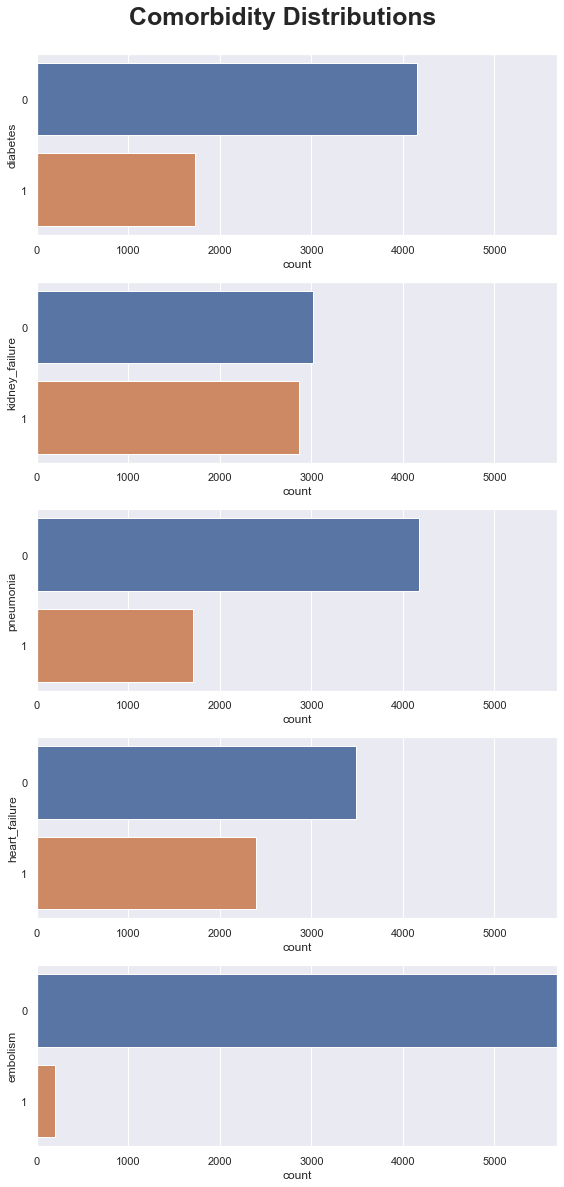

In [28]:
liste = ['diabetes', 'kidney_failure', 'pneumonia','heart_failure', 'embolism']
sns.set(style="darkgrid")
fig, ax =plt.subplots(5,1, figsize=(8,16) ) 
max_count = max([max(df[i].value_counts()) for i in liste])
A=sns.countplot(y=df['diabetes'],ax=ax[0],order=df.diabetes.value_counts().iloc[:2].index)
B=sns.countplot(y=df['kidney_failure'],ax=ax[1],order=df.kidney_failure.value_counts().iloc[:2].index)
C=sns.countplot(y=df['pneumonia'],ax=ax[2],order=df.pneumonia.value_counts().iloc[:2].index)
D=sns.countplot(y=df['heart_failure'],ax=ax[3],order=df.heart_failure.value_counts().iloc[:2].index)
E=sns.countplot(y=df['embolism'],ax=ax[4],order=df.embolism.value_counts().iloc[:2].index)
ax[0].set_xlim(0,max_count)
ax[1].set_xlim(0,max_count)
ax[2].set_xlim(0,max_count)
ax[3].set_xlim(0,max_count)
ax[4].set_xlim(0,max_count)
fig.tight_layout()
fig.suptitle("Comorbidity Distributions",fontsize=25, fontweight = 'bold', y= 1.03);

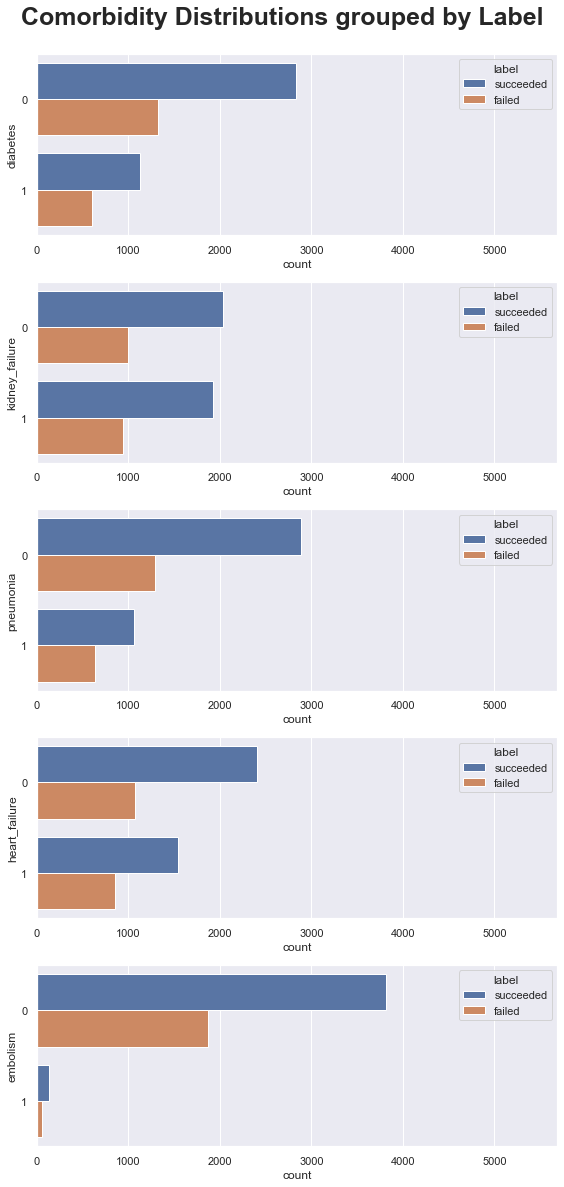

In [29]:
liste = ['diabetes', 'kidney_failure', 'pneumonia','heart_failure', 'embolism']
hue = df.label.apply(lambda x: 'succeeded' if x ==1 else 'failed')
sns.set(style="darkgrid")
fig, ax =plt.subplots(5,1, figsize=(8,16) ) 
max_count = max([max(df[i].value_counts()) for i in liste])
A=sns.countplot(y=df['diabetes'],hue=hue, ax=ax[0],order=df.diabetes.value_counts().iloc[:2].index)
B=sns.countplot(y=df['kidney_failure'],hue=hue,ax=ax[1],order=df.kidney_failure.value_counts().iloc[:2].index)
C=sns.countplot(y=df['pneumonia'],hue=hue,ax=ax[2],order=df.pneumonia.value_counts().iloc[:2].index)
D=sns.countplot(y=df['heart_failure'],hue=hue,ax=ax[3],order=df.heart_failure.value_counts().iloc[:2].index)
E=sns.countplot(y=df['embolism'],hue=hue,ax=ax[4],order=df.embolism.value_counts().iloc[:2].index)
ax[0].set_xlim(0,max_count)
ax[1].set_xlim(0,max_count)
ax[2].set_xlim(0,max_count)
ax[3].set_xlim(0,max_count)
ax[4].set_xlim(0,max_count)
fig.tight_layout()
fig.suptitle("Comorbidity Distributions grouped by Label",fontsize=25, fontweight = 'bold', y= 1.03);

## Course of certain features in the 24 hours prior to extubation